In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import Sequential, Model, Layer, layers, optimizers, losses, metrics, regularizers, callbacks
from matplotlib import pyplot as plt
import mplcyberpunk as mplnk

2024-06-05 12:11:18.073802: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 12:11:18.125290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 12:11:19.146072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [3]:
from config import Config
from utils import DataLoader

In [4]:
train_df = DataLoader().load_train_data()

In [5]:
train_df

,user_id,item_id,rating
0,716,836,4
1,620,422,1
2,547,289,3
3,758,385,4
4,627,197,5
...,...,...,...
79995,336,628,3
79996,749,637,1
79997,758,313,4
79998,380,139,1


In [6]:
plt.style.use('cyberpunk')

In [7]:
def plot_ratings_distribution(df):
    plt.figure(figsize=(10, 5))

    value_counts = df['rating'].value_counts()
    bars = plt.bar(x=value_counts.index, height=value_counts.values)
    percantages = value_counts / value_counts.sum() * 100

    font_dict = {
        'fontweight': 'normal',
        'fontfamily': 'sans-serif',
        'fontsize': 10,
        'color': 'white'
    }

    for bar, percantage in zip(bars, percantages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percantage:.2f}%', ha='center', va='bottom', fontdict=font_dict)

    mplnk.add_bar_gradient(bars)

    plt.xlabel('Rating', fontweight='bold')
    plt.show()

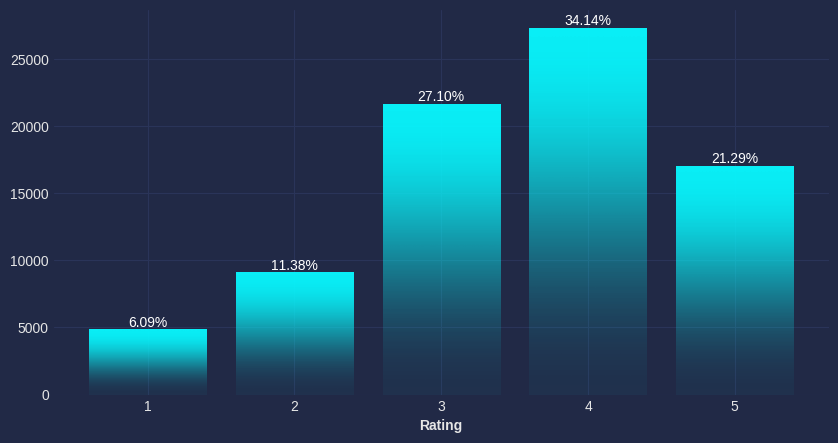

In [8]:
plot_ratings_distribution(train_df)

In [9]:
val_df = DataLoader().load_val_data()

In [10]:
val_df

,user_id,item_id,rating
0,655,911,2
1,200,88,4
2,763,607,4
3,500,714,2
4,690,163,3
...,...,...,...
19995,932,38,2
19996,154,874,3
19997,527,425,4
19998,464,333,4


In [11]:
x_train, x_test, y_train, y_test = train_df.values, val_df.values, train_df['rating'].values, val_df['rating'].values

In [12]:
x_train.shape

(80000, 3)

In [13]:
class MinMaxNormalization(Layer):
    
    def __init__(self, min_val, max_val, **kwargs):
        super().__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        scalar = lambda x: ((x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x))) * (max_val - min_val) + min_val
        self.lambda_layer = layers.Lambda(scalar)
        
    def call(self, inputs):
        return self.lambda_layer(inputs)

In [14]:
class Split(Layer):
    
    def __init__(self, splits, **kwargs):
        super(Split, self).__init__(**kwargs)
        self.splits = splits
        self.reshape = layers.Reshape(target_shape=(1,))
    
    def call(self, inputs) -> list[tf.Tensor]:
        if isinstance(inputs, (list, tuple)):
            inputs = tf.stack(inputs, axis=1)
        
        splits = tf.split(inputs, self.splits, axis=1)
        
        return [self.reshape(split) for split in splits]

In [15]:
class DeepMF(Model):
    
    def __init__(
        self,
        latent_dim:int = 5, 
        num_users:int = Config.Vars.NUM_USERS,
        num_items:int = Config.Vars.NUM_ITEMS,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_users = num_users
        self.num_items = num_items
        self.split = Split(splits=3, name='split')
        self.rating = layers.Identity(name='rating')
        self.user_embedding = layers.Embedding(self.num_users + 1, self.latent_dim, name='user_embedding')
        self.user_flatten = layers.Flatten(name='user_flatten')
        self.item_embedding = layers.Embedding(self.num_items + 1, self.latent_dim, name='item_embedding')
        self.item_flatten = layers.Flatten(name='item_flatten')
        self.dot = layers.Dot(axes=1, name='dot')
        self.concatenate1 = layers.Concatenate(axis=1, name='concatenate1')
        self.reshape = layers.Reshape(target_shape=(-1,), name='reshape')
        self.concatenate2 = layers.Concatenate(axis=1, name='concatenate2')
    
    def call(self, inputs):
        user_id, item_id, ratings = self.split(inputs)
        user_emb = self.user_embedding(user_id)
        user_emb = self.user_flatten(user_emb)
        item_emb = self.item_embedding(item_id)
        item_emb = self.item_flatten(item_emb)
        rating_vec = self.dot([user_emb, item_emb])
        embeddings = self.concatenate1([user_emb, item_emb])
        norm_ratings = self.rating(ratings)
        # norm_ratings = self.norm(ratings)
        norm_ratings = self.reshape(norm_ratings)
        embedded_data = self.concatenate2([embeddings, norm_ratings])
        return rating_vec, embedded_data
    
    def predict(self, x):
        _, embedded_data = self.call(x)
        return embedded_data
    
    def train_step(self, data):
        inputs, output = data
        
        with tf.GradientTape() as tape:
            rating_vec, _ = self.call(inputs)
            loss = self.compute_loss(y=output, y_pred=rating_vec)
            
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            'mse_loss': loss,
            **self.compute_metrics(x=inputs[0], y=output, y_pred=rating_vec)
        }
    
    def summary(self):
        model = self.build_graph()
        return model.summary()
    
    def build_graph(self):
        x = (layers.Input(shape=(3,)))
        return Model(inputs=x, outputs=self.call(x))

In [16]:
deepmf = DeepMF()
deepmf.compile(
    optimizer=optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    metrics=[metrics.R2Score()]
)

2024-06-05 12:11:33.583127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 12:11:33.754638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 12:11:33.754806: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
deepmf.fit(
    [x_train[:, 0], x_train[:, 1], x_train[:, 2]],
    y_train,
    validation_data=([x_test[:, 0], x_test[:, 1], x_test[:, 2]], y_test),
    epochs=10,
    batch_size=32,
    validation_freq=3
)

Epoch 1/10


I0000 00:00:1717569699.783635   15613 service.cc:145] XLA service 0x74d4e00014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717569699.783677   15613 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-06-05 12:11:39.840542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-05 12:11:39.988963: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  83/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0000e+00 - mse_loss: 13.6767 - r2_score: -9.8791

I0000 00:00:1717569700.385885   15613 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0000e+00 - mse_loss: 11.4419 - r2_score: -9.3994
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step - loss: 0.0000e+00 - mse_loss: 3.1887 - r2_score: -2.3421
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0000e+00 - mse_loss: 1.4725 - r2_score: -0.2838 - val_loss: 1.2603 - val_r2_score: 0.0033
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0000e+00 - mse_loss: 1.1038 - r2_score: 0.0918
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 822us/step - loss: 0.0000e+00 - mse_loss: 0.9800 - r2_score: 0.2197
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 999us/step - loss: 0.0000e+00 - mse_loss: 0.9306 - r2_score: 0.2741 - val_loss: 0.9456 - val_r2_score: 0.2522
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0000e+00 - mse_loss: 0.9067 - r2_score: 0.2985
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0000e+00 - mse_loss: 0.8937 - r2_score: 0.2983
Epoch 9/10
2500/2500 ━━━━━━━━

In [18]:
embedded_data = deepmf.predict([x_train[:, 0], x_train[:, 1], x_train[:, 2]])
embedded_data.shape

TensorShape([80000, 11])

In [19]:
@keras.utils.register_keras_serializable(package='Custom', name='GAN')
class GAN(Model):
    
    def __init__(
        self,
        generator: Model,
        discriminator: Model,
        noise_dim: int = 100,
        **kwargs
    ):
        super(GAN, self).__init__(**kwargs)
        self.noise_dim = noise_dim
        self.generator = generator
        self.discriminator = discriminator
    
    def call(self, inputs, training=False):
        noise_vec, input_tensor = inputs
        
        real_output = self.discriminator(input_tensor, training=True)
        gen_tensor = self.generator(noise_vec, training=True)
        gen_output = self.discriminator(gen_tensor, training=True)
        
        return gen_tensor, real_output, gen_output
    
    def compile(
        self,
        gen_optimizer: keras.Optimizer,
        disc_optimizer: keras.Optimizer,
        **kwargs
    ):
        super(GAN, self).compile(**kwargs)
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
    
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        _, real_output, gen_output = y_pred
        
        gen_loss = losses.binary_crossentropy(tf.ones_like(gen_output), gen_output)
        disc_loss = losses.binary_crossentropy(tf.ones_like(real_output), real_output) + losses.binary_crossentropy(tf.zeros_like(gen_output), gen_output)
        
        return {
            'gen_loss': gen_loss,
            'disc_loss': disc_loss
        }
    
    def train_step(self, inputs: tf.Tensor):
        
        noise_vec = tf.random.normal((tf.shape(inputs)[0], self.noise_dim))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            _, real_output, gen_output = self.call(inputs=(noise_vec, inputs), training=True)
            loss = self.compute_loss(y_pred=[inputs, real_output, gen_output])
        
        gen_grads = gen_tape.gradient(loss['gen_loss'], self.generator.trainable_weights)
        disc_grads = disc_tape.gradient(loss['disc_loss'], self.discriminator.trainable_weights)
        
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))
        
        return {
            'gen_loss': loss['gen_loss'],
            'disc_loss': loss['disc_loss'],
            **self.compute_metrics(x=noise_vec, y=inputs, y_pred=[inputs, real_output, gen_output])
        }
    
    def predict(self, x):
        return self.generator(x)
    
    def summary(self, **kwargs):
        model = self.build_graph()
        return model.summary(**kwargs)
    
    def build_graph(self):
        if isinstance(self.discriminator, keras.src.models.Functional):
            input_shape = self.discriminator.layers[1].input.shape[1:]
        else:
            input_shape = self.discriminator.layers[0].input.shape[0:]
        
        input_tensor = layers.Input(shape=input_shape)
        noise_vec = layers.Input(shape=(self.noise_dim,))
        return Model(inputs=[noise_vec, input_tensor], outputs=self.call((noise_vec, input_tensor)))
    
    def get_config(self):
        config = super(Model, self).get_config()
        config.update({
            'generator': self.generator.get_config(),
            'discriminator': self.discriminator.get_config(),
            'noise_dim': self.noise_dim
        })
        return config
    
    @classmethod
    def from_config(cls, config: dict):
        generator = Model.from_config(config.pop('generator'))
        discriminator = Model.from_config(config.pop('discriminator'))
        return cls(generator=generator, discriminator=discriminator, **config)

In [20]:
def build_generator():
    noise_dim = 100
    latent_dim = 5
    
    inputs = layers.Input(shape=(noise_dim,), name='gen_input')
    x = layers.Dense(units=10, name='dense_1')(inputs)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu_1')(x)
    x = layers.BatchNormalization(momentum=0.8, name='batch_norm')(x)
    x = layers.Dense(20, name='dense_2')(x)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu_2')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    outputs = layers.Dense(units=latent_dim * 2 + 1, name='dense3')(x)
    
    return Model(inputs=inputs, outputs=outputs, name='generator')

In [21]:
def build_discriminator():
    latent_dim = 5
    
    inputs = layers.Input(shape=(latent_dim * 2 + 1,), name='disc_input')
    x = layers.Dense(units=4, name='dense4')(inputs)
    x = layers.LeakyReLU(negative_slope=0.2, name='leaky_relu1')(x)
    x = layers.Dense(units=1, name='dense5')(x)
    x = layers.Activation('sigmoid', name='sigmoid')(x)

    return Model(inputs=inputs, outputs=x, name='discriminator')

In [22]:
gan = GAN(generator=build_generator(), discriminator=build_discriminator())
gan.compile(
    gen_optimizer=optimizers.Adam(),
    disc_optimizer=optimizers.Adam()
)

In [23]:
gan.fit(
    x=embedded_data,
    epochs=10,
    batch_size=32,
)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - disc_loss: 1.3741 - gen_loss: 0.7348 - loss: 0.0000e+00
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - disc_loss: 1.3719 - gen_loss: 0.7457 - loss: 0.0000e+00
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - disc_loss: 1.3803 - gen_loss: 0.7112 - loss: 0.0000e+00
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - disc_loss: 1.3784 - gen_loss: 0.7096 - loss: 0.0000e+00
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - disc_loss: 1.3735 - gen_loss: 0.7250 - loss: 0.0000e+00
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - disc_loss: 1.3951 - gen_loss: 0.6946 - loss: 0.0000e+00
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - disc_loss: 1.3820 - gen_loss: 0.7116 - loss: 0.0000e+00
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - disc_loss: 1.3886 - gen_loss: 0.7290 - loss: 0.0000e+00
Epoch 9/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - disc_loss: 1.3712 - gen_loss: 0.7160 - loss: 0.0

In [24]:
gan.summary(expand_nested=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generator           │ (None, 11)        │      1,501 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ gen_input      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dense_1        │ (None, 10)        │      1,010 │ -                 │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ leaky_relu_1   │ (None, 10)        │          0 │ -                 │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ batch_norm     │ (None, 10)        │         40 │ -                 │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dense_2        │ (None, 20)        │        220 │ -                 │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ leaky_relu_2   │ (None, 20)        │          0 │ -                 │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dropout        │ (None, 20)        │          0 │ -                 │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dense3 (Dense) │ (None, 11)        │        231 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator       │ (None, 1)         │         53 │ input_layer[0][0… │
│ (Functional)        │                   │            │ generator[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ disc_input     │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dense4 (Dense) │ (None, 4)         │         48 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ leaky_relu1    │ (None, 4)         │          0 │ -                 │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ dense5 (Dense) │ (None, 1)         │          5 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ sigmoid        │ (None, 1)         │          0 │ -                 │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,554 (6.07 KB)

 Trainable params: 1,534 (5.99 KB)

 Non-trainable params: 20 (80.00 B)

In [25]:
STD_DEV = 1.5 # You can stablish the fake samples variability by setting this value
noise = np.random.normal(0, STD_DEV, (50000, 100))

In [26]:
augmented = gan.predict(noise).numpy()

In [27]:
augmented[:, -1] = MinMaxNormalization(min_val=0, max_val=5)(augmented[:, -1]).numpy()

In [28]:
FAKE_SAMPLES = 50000
latent_dim = 5

In [29]:
from sklearn.cluster import KMeans

testing_users = [500, 1000]
testing_items = [1000, 2000]

for K in testing_users:   
    clustering_users = KMeans(n_clusters=K, n_init=1, max_iter= 100, verbose=1)
    cluster_users = clustering_users.fit_predict(augmented[:FAKE_SAMPLES,:latent_dim])  
    np.save('cluster_users' + str(FAKE_SAMPLES) + '_' + str(K), cluster_users)  
    print("end cluster users: " + str(K))

for K in testing_items:   
    clustering_items = KMeans(n_clusters=K, n_init=1, max_iter= 100, verbose=1)
    cluster_items = clustering_items.fit_predict(augmented[:FAKE_SAMPLES,latent_dim:-1])  
    np.save('cluster_items' + str(FAKE_SAMPLES) + '_' + str(K), cluster_items)   
    print("end cluster items: " + str(K))

Initialization complete
Iteration 0, inertia 18.62461280822754.
Iteration 1, inertia 17.08466339111328.
Iteration 2, inertia 16.681238174438477.
Iteration 3, inertia 16.490314483642578.
Iteration 4, inertia 16.36307716369629.
Iteration 5, inertia 16.270465850830078.
Iteration 6, inertia 16.20012664794922.
Iteration 7, inertia 16.145320892333984.
Iteration 8, inertia 16.103849411010742.
Iteration 9, inertia 16.068416595458984.
Iteration 10, inertia 16.036890029907227.
Iteration 11, inertia 16.007793426513672.
Iteration 12, inertia 15.982200622558594.
Iteration 13, inertia 15.962409973144531.
Iteration 14, inertia 15.946930885314941.
Iteration 15, inertia 15.932960510253906.
Iteration 16, inertia 15.920207023620605.
Iteration 17, inertia 15.907771110534668.
Iteration 18, inertia 15.895023345947266.
Iteration 19, inertia 15.880699157714844.
Iteration 20, inertia 15.867758750915527.
Iteration 21, inertia 15.858323097229004.
Iteration 22, inertia 15.850574493408203.
Iteration 23, inertia 15

In [30]:
for Ku in testing_users:
    cluster_users = np.load('cluster_users' + str(FAKE_SAMPLES) + '_' + str(Ku)+'.npy')
    for Ki in testing_items:
        cluster_items = np.load('cluster_items' + str(FAKE_SAMPLES) + '_' + str(Ki)+'.npy')
        f = open ('synthetic_'+str(FAKE_SAMPLES)+'_'+str(Ku)+'_'+str(Ki)+'.txt','w')
        f.write('user,item,rating\n')
        
        for i in range(FAKE_SAMPLES):
            us = str(cluster_users[i])
            it = str(cluster_items[i])
            ra = augmented[i,-1:][0]
            if ra > 5.:
                ra = 5
            elif ra < 1:
                ra = 1
            else:
                ra = np.round(ra)
            f.write(us + "," + it + "," + str(ra) + "\n")
        f.close()
        print("synthetic dataset " + str(Ku) + ', ' + str(Ki) + " has been created")
      

synthetic dataset 500, 1000 has been created
synthetic dataset 500, 2000 has been created
synthetic dataset 1000, 1000 has been created
synthetic dataset 1000, 2000 has been created


In [31]:
df = pd.read_csv('synthetic_50000_500_1000.txt')

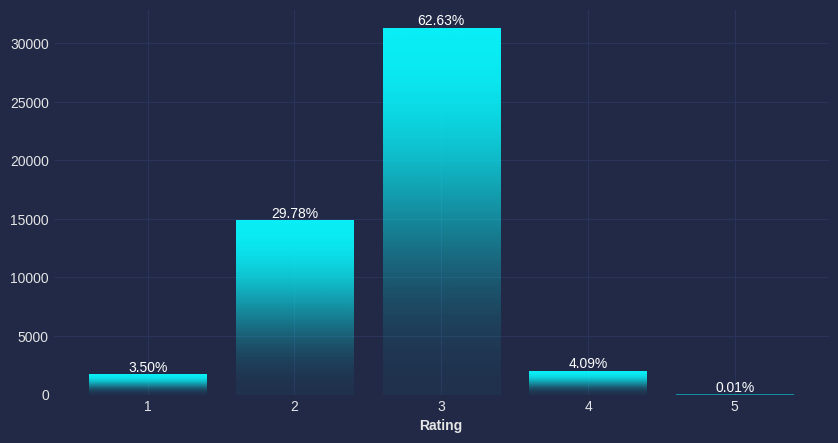

In [32]:
plot_ratings_distribution(df)